In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import label_binarize
import numpy as np
from itertools import cycle

In [3]:
np.random.seed(42)

KMeans - Unbalanced Dataset

In [4]:
df = pd.read_csv("../Datasets/Unbalanced_Multiclass.csv")
df.head()

,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9,Feature10,...,Feature21,Feature22,Feature23,Feature24,Feature25,Feature26,Feature27,Feature28,Feature29,target
0,1.942833,1.793557,-6.121474,-1.031132,0.487107,-0.346116,0.242493,-0.255091,-1.933793,0.456129,...,0.021294,-0.876791,-2.804382,-0.772752,0.902250,-0.283821,1.158110,-0.703144,-1.142507,8
1,-0.498266,4.290355,0.924083,-1.281493,8.153378,-2.302476,0.615296,-3.871441,1.491185,3.666561,...,-0.030226,1.076776,-1.426662,0.743057,0.212868,1.043947,0.948273,0.706128,-0.491125,8
2,-1.027512,3.363755,1.828574,-0.495802,7.458820,-2.484852,0.378415,-2.248700,-1.301424,4.136351,...,0.472101,1.206932,-0.923404,0.566657,0.293071,-0.145078,1.759649,0.516351,0.492429,8
3,2.736756,-2.241731,0.404660,-0.167861,-0.125442,0.496706,1.664382,-1.271026,0.213782,0.962099,...,-1.376614,-0.559114,-0.335620,0.088591,0.080121,-0.085828,0.038390,-0.096909,-0.426436,8
4,0.685796,0.223385,-2.080131,-0.011414,4.090118,0.650177,2.411078,2.637664,-1.594057,0.283371,...,0.540901,0.354731,-0.933172,-0.888606,0.902017,0.506791,0.640292,0.129010,0.092228,8


In [5]:
print("Original class distribution:")
print(df['target'].value_counts())

Original class distribution:
target
8     367
3      80
2      16
1      15
0      15
7       7
13      6
9       4
11      2
4       1
5       1
10      1
6       1
12      1
Name: count, dtype: int64


In [6]:
df_filtered = df.query("target not in [4,5,10,6,12]")
df_filtered['target'].value_counts()

target
8     367
3      80
2      16
1      15
0      15
7       7
13      6
9       4
11      2
Name: count, dtype: int64

In [7]:
X = df_filtered.drop('target', axis=1)
y = df_filtered['target']

In [8]:
#scaler = StandardScaler()
#X_train = scaler.fit_transform(X_train)
#X_test = scaler.transform(X_test)

In [9]:
num_classes = y.nunique()
print(f"\nNumber of classes after filtering: {num_classes}")


Number of classes after filtering: 9


In [10]:
kmeans = KMeans(
    n_clusters=num_classes,
    init='k-means++',
    max_iter=500,
    random_state=42,
    n_init=20
)

In [11]:
kmeans.fit(X)
y_pred = kmeans.predict(X)

c:\Users\rajit\anaconda3\envs\ml_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


In [12]:
def map_clusters_to_labels(y_true, y_cluster):
    mapping = {}
    for cluster in np.unique(y_cluster):
        class_counts = y_true[y_cluster == cluster].value_counts()
        if not class_counts.empty:
            mapping[cluster] = class_counts.idxmax()
    return np.array([mapping[cluster] for cluster in y_cluster])

y_pred_mapped = map_clusters_to_labels(y, y_pred)

In [13]:
classes = sorted(y.unique())
target_names = [f"Class {c}" for c in classes]
accuracy = accuracy_score(y, y_pred_mapped)

print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report(y, y_pred_mapped, target_names=target_names))

Accuracy: 0.72
Classification Report:
              precision    recall  f1-score   support

     Class 0       1.00      0.07      0.12        15
     Class 1       0.00      0.00      0.00        15
     Class 2       0.00      0.00      0.00        16
     Class 3       0.00      0.00      0.00        80
     Class 7       0.00      0.00      0.00         7
     Class 8       0.72      1.00      0.84       367
     Class 9       0.00      0.00      0.00         4
    Class 11       0.00      0.00      0.00         2
    Class 13       0.00      0.00      0.00         6

    accuracy                           0.72       512
   macro avg       0.19      0.12      0.11       512
weighted avg       0.54      0.72      0.60       512



c:\Users\rajit\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rajit\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rajit\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


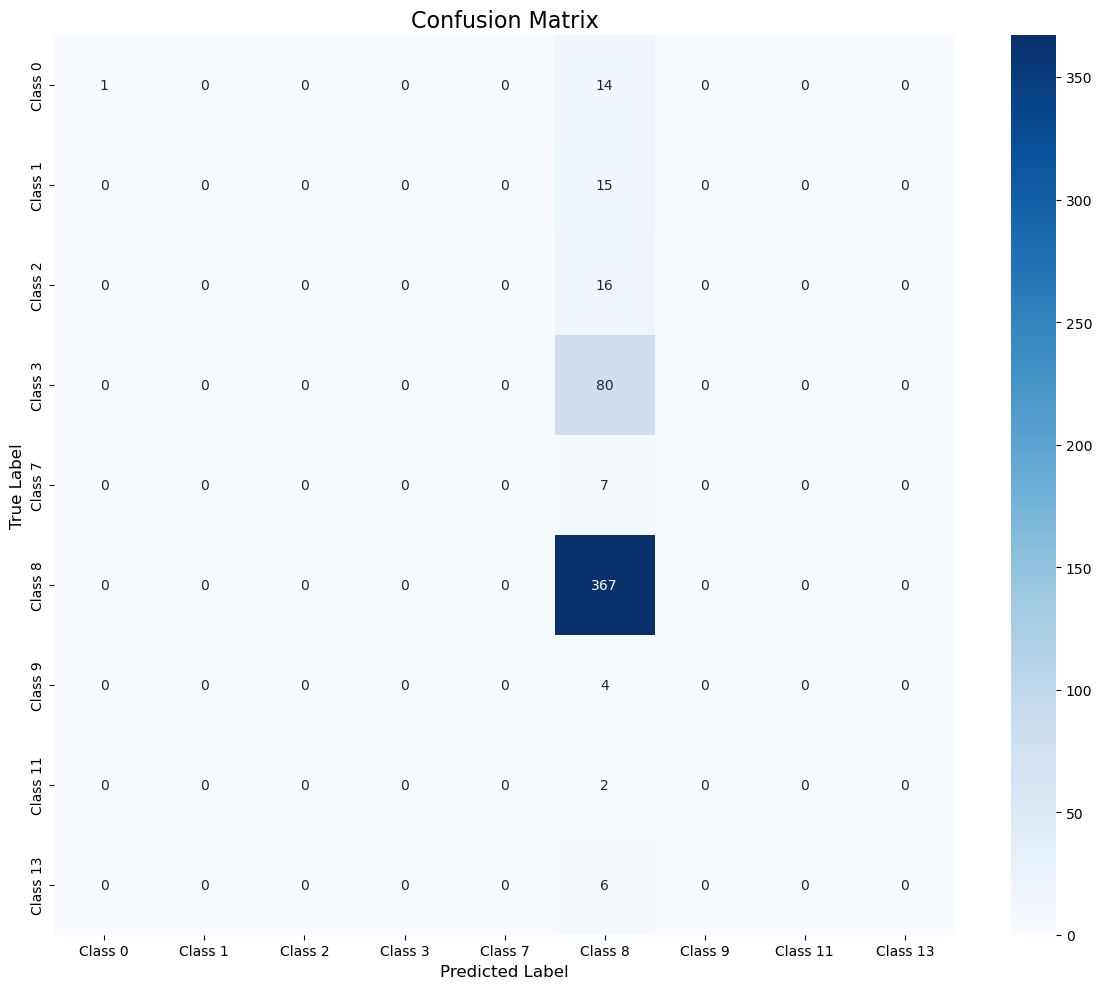

In [14]:
cm = confusion_matrix(y, y_pred_mapped)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names,
            yticklabels=target_names)
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.show()

No cluster mapped to class 1, skipping
No cluster mapped to class 2, skipping
No cluster mapped to class 3, skipping
No cluster mapped to class 7, skipping
No cluster mapped to class 9, skipping
No cluster mapped to class 11, skipping
No cluster mapped to class 13, skipping


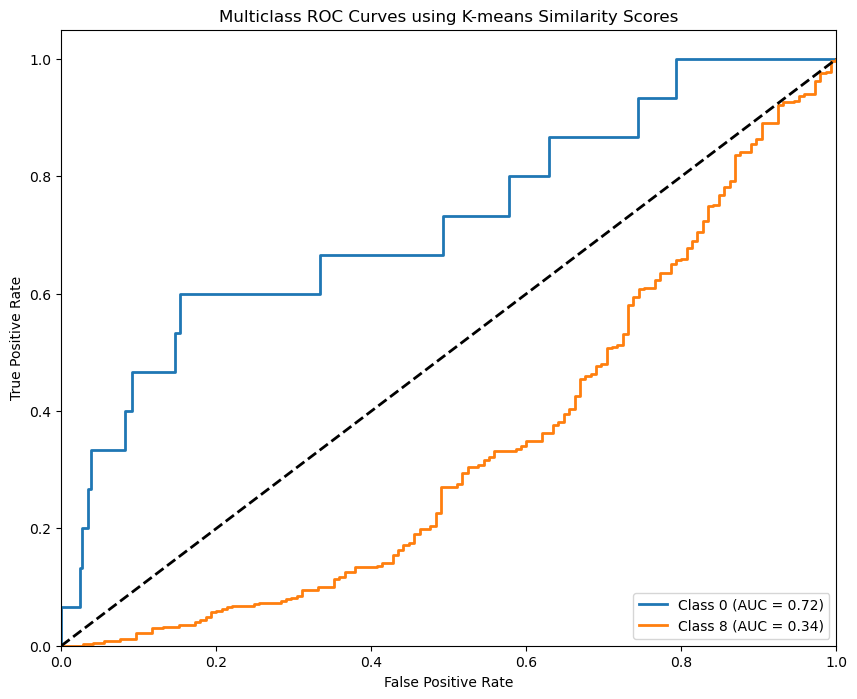

In [15]:
from scipy.spatial.distance import cdist
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

distances = cdist(X, kmeans.cluster_centers_, 'euclidean')
similarity_scores = 1 / (1 + distances)

y_bin = label_binarize(y, classes=classes)
n_classes = y_bin.shape[1]

cluster_to_class = {}
for cluster in np.unique(y_pred):
    cluster_mask = (y_pred == cluster)
    if cluster_mask.any():
        cluster_to_class[cluster] = y[cluster_mask].mode()[0]


plt.figure(figsize=(10, 8))
colors = cycle(['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
                '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])

for class_idx, class_label in enumerate(classes):
    try:
        cluster_idx = [k for k, v in cluster_to_class.items() if v == class_label][0]
    except IndexError:
        print(f"No cluster mapped to class {class_label}, skipping")
        continue
    
    class_scores = similarity_scores[:, cluster_idx]
    
    fpr, tpr, _ = roc_curve(y_bin[:, class_idx], class_scores)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, color=next(colors),
             lw=2, label=f'Class {class_label} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curves using K-means Similarity Scores')
plt.legend(loc="lower right")
plt.show()

KMeans - Balanced Dataset

In [16]:
df = pd.read_csv("../Datasets/Balanced_Multiclass.csv")
df.head()

,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9,Feature10,...,Feature21,Feature22,Feature23,Feature24,Feature25,Feature26,Feature27,Feature28,Feature29,target
0,1.942833,1.793557,-6.121474,-1.031132,0.487107,-0.346116,0.242493,-0.255091,-1.933793,0.456129,...,0.021294,-0.876791,-2.804382,-0.772752,0.902250,-0.283821,1.158110,-0.703144,-1.142507,8
1,-0.498266,4.290355,0.924083,-1.281493,8.153378,-2.302476,0.615296,-3.871441,1.491185,3.666561,...,-0.030226,1.076776,-1.426662,0.743057,0.212868,1.043947,0.948273,0.706128,-0.491125,8
2,-1.027512,3.363755,1.828574,-0.495802,7.458820,-2.484852,0.378415,-2.248700,-1.301424,4.136351,...,0.472101,1.206932,-0.923404,0.566657,0.293071,-0.145078,1.759649,0.516351,0.492429,8
3,2.736756,-2.241731,0.404660,-0.167861,-0.125442,0.496706,1.664382,-1.271026,0.213782,0.962099,...,-1.376614,-0.559114,-0.335620,0.088591,0.080121,-0.085828,0.038390,-0.096909,-0.426436,8
4,0.685796,0.223385,-2.080131,-0.011414,4.090118,0.650177,2.411078,2.637664,-1.594057,0.283371,...,0.540901,0.354731,-0.933172,-0.888606,0.902017,0.506791,0.640292,0.129010,0.092228,8


In [17]:
df['target'].value_counts()

target
8     367
3     367
13    367
2     367
4     367
5     367
6     367
10    367
1     367
11    367
7     367
0     367
12    367
9     367
Name: count, dtype: int64

In [18]:
X = df.drop('target', axis=1)
y = df['target']

In [19]:
#scaler = StandardScaler()
#X_train = scaler.fit_transform(X_train)
#X_test = scaler.transform(X_test)

In [20]:
num_classes = y.nunique()
print(f"\nNumber of classes after filtering: {num_classes}")


Number of classes after filtering: 14


In [21]:
kmeans = KMeans(
    n_clusters=num_classes,
    init='k-means++',
    max_iter=500,
    random_state=42,
    n_init=20
)

In [22]:
kmeans.fit(X)
y_pred = kmeans.predict(X)

In [23]:
def map_clusters_to_labels(y_true, y_cluster):
    mapping = {}
    for cluster in np.unique(y_cluster):
        class_counts = y_true[y_cluster == cluster].value_counts()
        if not class_counts.empty:
            mapping[cluster] = class_counts.idxmax()
    return np.array([mapping[cluster] for cluster in y_cluster])

y_pred_mapped = map_clusters_to_labels(y, y_pred)

In [24]:
classes = sorted(y.unique())
target_names = [f"Class {c}" for c in classes]
accuracy = accuracy_score(y, y_pred_mapped)

print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report(y, y_pred_mapped, target_names=target_names))

Accuracy: 0.63
Classification Report:
              precision    recall  f1-score   support

     Class 0       1.00      0.04      0.07       367
     Class 1       0.00      0.00      0.00       367
     Class 2       0.55      0.22      0.32       367
     Class 3       0.39      0.54      0.45       367
     Class 4       0.81      1.00      0.90       367
     Class 5       0.98      1.00      0.99       367
     Class 6       0.96      1.00      0.98       367
     Class 7       0.00      0.00      0.00       367
     Class 8       0.29      0.54      0.38       367
     Class 9       0.60      0.48      0.53       367
    Class 10       0.69      1.00      0.82       367
    Class 11       0.38      1.00      0.55       367
    Class 12       0.96      1.00      0.98       367
    Class 13       0.89      1.00      0.94       367

    accuracy                           0.63      5138
   macro avg       0.61      0.63      0.56      5138
weighted avg       0.61      0.63      0.5

c:\Users\rajit\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rajit\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rajit\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


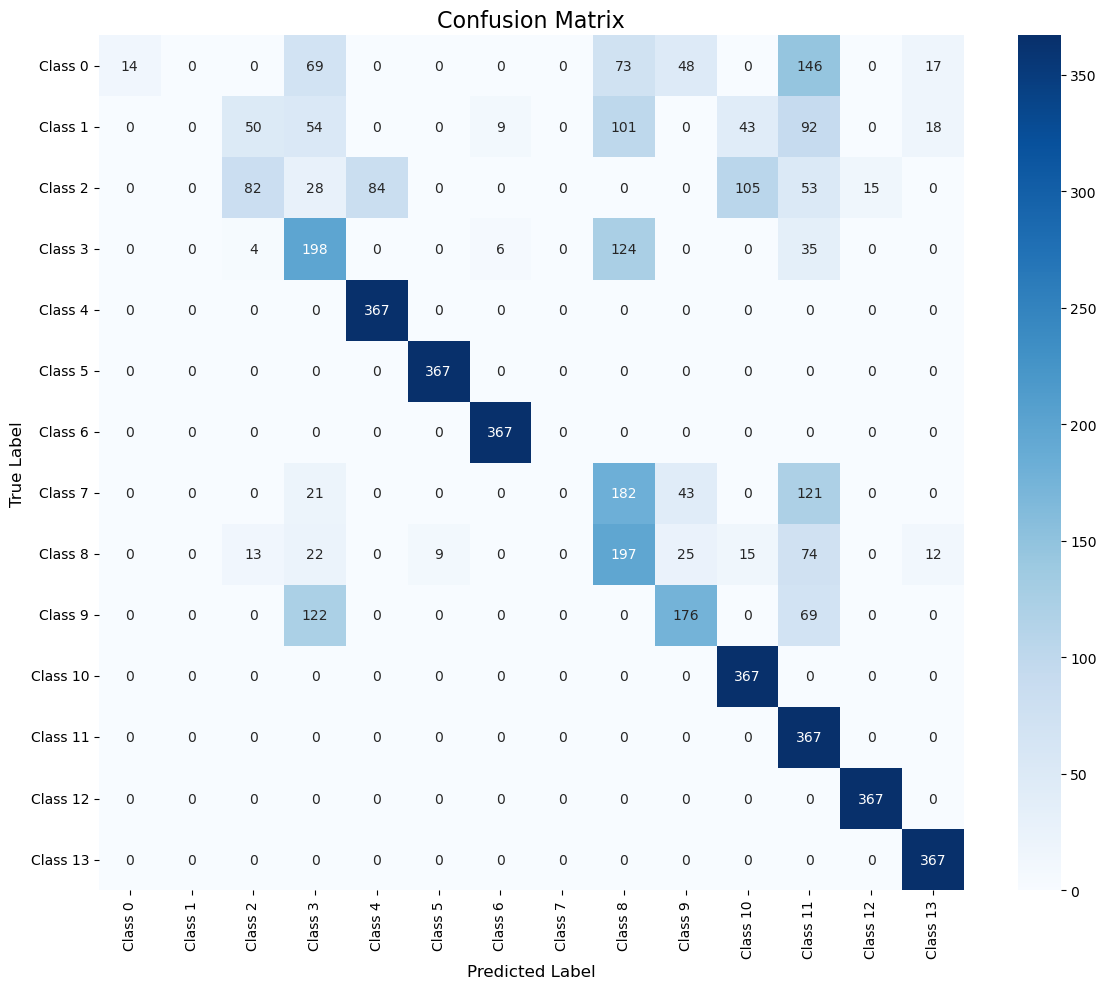

In [25]:
cm = confusion_matrix(y, y_pred_mapped)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names,
            yticklabels=target_names)
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.show()

No cluster mapped to class 1, skipping
No cluster mapped to class 7, skipping


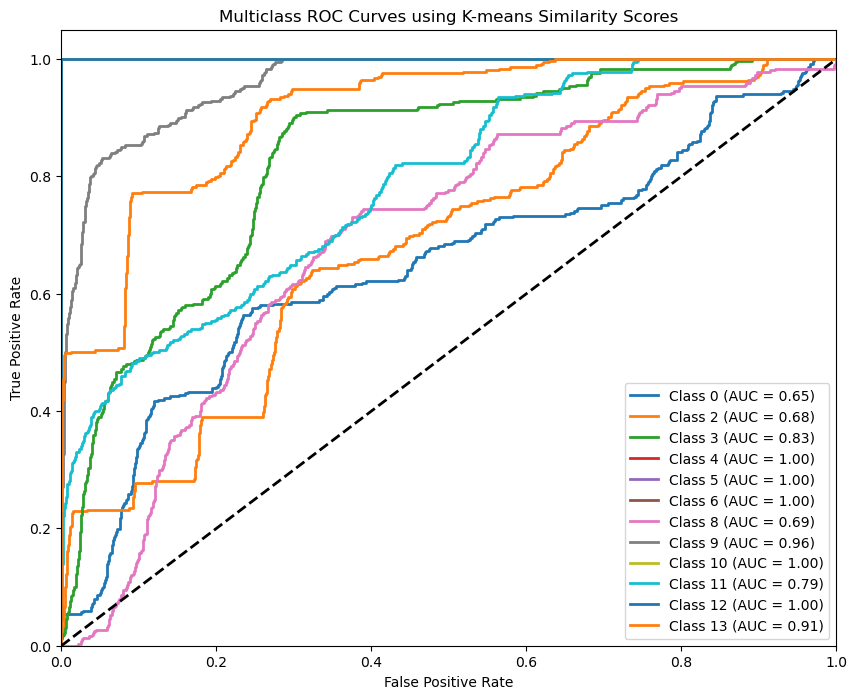

In [26]:
from scipy.spatial.distance import cdist
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize


distances = cdist(X, kmeans.cluster_centers_, 'euclidean')
similarity_scores = 1 / (1 + distances)

y_bin = label_binarize(y, classes=classes)
n_classes = y_bin.shape[1]

cluster_to_class = {}
for cluster in np.unique(y_pred):
    cluster_mask = (y_pred == cluster)
    if cluster_mask.any():
        cluster_to_class[cluster] = y[cluster_mask].mode()[0]


plt.figure(figsize=(10, 8))
colors = cycle(['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
                '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])

for class_idx, class_label in enumerate(classes):
    try:
        cluster_idx = [k for k, v in cluster_to_class.items() if v == class_label][0]
    except IndexError:
        print(f"No cluster mapped to class {class_label}, skipping")
        continue
    
    class_scores = similarity_scores[:, cluster_idx]
    
    fpr, tpr, _ = roc_curve(y_bin[:, class_idx], class_scores)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, color=next(colors),
             lw=2, label=f'Class {class_label} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curves using K-means Similarity Scores')
plt.legend(loc="lower right")
plt.show()